In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
path = "./Data/Flickr8k.token.txt"
captions = readTextFile(path)
captions = captions.split("\n")[:-1]

In [4]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [5]:
 print(len(captions))

40460


In [6]:
descriptions = {}
for x in captions:
    first,second = x.split("\t")
    img_name = first.split(".")[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    descriptions[img_name].append(second)

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

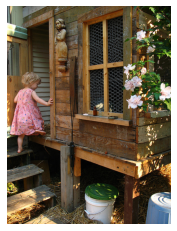

In [8]:
IMG_PATH = "Data/Images/"

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# Data Cleaning

In [9]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [10]:
clean_text("A cat is sitting over the house #64")

'cat is sitting over the house'

In [11]:
for key,captions_list in descriptions.items():
    for i in range(len(captions_list)):
        captions_list[i] = clean_text(captions_list[i])

In [12]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
with open("descriptions1.txt", "w") as f:
    f.write(str(descriptions))

# Vocabulary

In [14]:
descriptions = None
with open("descriptions1.txt",'r') as f:
    descriptions = f.read()
descriptions = json.loads(descriptions.replace("'","\""))

In [15]:
type(descriptions)

dict

In [16]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab size : %d"%len(vocab))

Vocab size : 8424


In [17]:
#total words across all sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total words: %d"%len(total_words))

Total words: 373837


In [18]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [19]:
# Filter Words according to a frequency threshold
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [23]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt  if x[1] >threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [26]:
len(total_words)

1845